# Engineering Transparency into Your Binomial Machine Learning Model with Python (Based on simulated data)

### Partial dependence, ICE, and Shapley explanations
In this notebook a gradient boosting machine (GBM) is trained to predict a binomial target using a simulated dataset, Python, NumPy, Pandas, and XGBoost. First, the dataset is simulated. Then the binomial model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

In addition to above, `eli5` and `LIME` variable importances are also presented globally and locally for comparision purposes. 

### Python imports

In [1]:
import sys
sys.path.append("../..") 

import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap
import eli5
import h2o
import os

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from lime_explainer import LIMEExplainer
from data_maker_and_getter import DataMakerAndGetter

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

cwd = os.getcwd()
print("Current working directory is " + cwd)

Current working directory is /Users/navdeepgill/Desktop/git/interpretable-ml/notebooks/simulated/binomial


In [2]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/navdeepgill/Desktop/h2oai/env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpyq31lcrt
  JVM stdout: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpyq31lcrt/h2o_navdeepgill_started_from_python.out
  JVM stderr: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpyq31lcrt/h2o_navdeepgill_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_navdeepgill_ovudzg
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


### Known Signal Generating Function for Simulated Data
The outcome, `y (target)`, is generated based on the following formula:

$$y = x_1 * x_4 + |x_8| * (x_9)^2$$

This indicates that `y (target)` is highly correlated to `x1`, `x4`, `x8`, and `x9` which translate to `num1`, `num4`, `num8`, and `num9` in the generated dataset below.

# Data Generation

In [3]:
ds_ = DataMakerAndGetter(nrows=30000, target='binary', one_function=True, noise=True, seed=12345)
data = ds_.make_random_with_signal()
data.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
0,-0.204708,0.478943,-0.519439,-0.555730,1.965781,1.393406,0.092908,0.281746,0.769023,1.246435,1.007189,-1.296221,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.0,0,1.0
1,0.476985,3.248944,-1.021228,-0.577087,0.124121,0.302614,0.523772,0.000940,1.343810,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757,0.560145,-1.265934,0.119827,-1.063512,0.332883,-2.359419,-0.199543,0.0,1,1.0
2,-1.541996,-0.970736,-1.307030,0.286350,0.377984,-0.753887,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,0.862580,-0.010032,0.050009,0.0,2,1.0
3,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,1.0,3,1.0
4,1.010737,1.824875,-0.997518,0.850591,-0.131578,0.912414,0.188211,2.169461,-0.114928,2.003697,0.029610,0.795253,0.118110,-0.748532,0.584970,0.152677,-1.565657,-0.562540,-0.032664,-0.929006,-0.482573,1.0,4,1.0


### Assign modeling roles

In [4]:
#Assign target and inputs for GBM
y = 'target'
X = [name for name in data.columns if name not in [y,'row_id','function']]
print('y =', y)
print('X =', X)

y = target
X = ['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12', 'num13', 'num14', 'num15', 'num16', 'num17', 'num18', 'num19', 'num20', 'num21']


### Display descriptive statistics

In [5]:
data.describe() #Display descriptive statistics for all columns

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,num13,num14,num15,num16,num17,num18,num19,num20,num21,target,row_id,function
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.0
mean,0.012590,0.002605,-0.000579,0.007462,0.005243,-0.002555,0.000550,0.002338,0.001087,-0.001469,-0.003344,0.005400,0.012990,-0.009158,-0.004660,-0.003395,0.009174,0.004225,-0.002435,0.002337,-0.005233,0.423867,14999.500000,1.0
std,0.998170,0.999171,0.996087,0.998874,0.996718,1.002234,0.994695,0.988403,0.993752,0.999242,0.997853,1.003659,1.002058,0.999407,1.005237,1.002263,1.007168,1.002283,0.993666,0.995449,0.996649,0.494178,8660.398374,0.0
min,-4.263327,-3.892513,-4.150859,-3.793212,-3.916409,-3.628800,-3.776349,-4.501229,-3.558984,-4.092063,-4.106707,-4.179609,-4.071903,-4.301598,-3.905666,-3.926523,-3.924861,-3.957649,-5.057590,-4.148729,-4.250292,0.000000,0.000000,1.0
25%,-0.654347,-0.670167,-0.674723,-0.676910,-0.666627,-0.679165,-0.670021,-0.665613,-0.676052,-0.667745,-0.678147,-0.671923,-0.659966,-0.690996,-0.679288,-0.680801,-0.670903,-0.673475,-0.666851,-0.665201,-0.672575,0.000000,7499.750000,1.0
50%,0.006505,0.001560,-0.001632,0.008760,0.007613,-0.008698,0.006025,0.004705,0.001685,0.001303,-0.004356,0.004913,0.009361,-0.011090,-0.015657,-0.006959,0.003619,-0.003938,-0.006281,-0.000754,-0.004740,0.000000,14999.500000,1.0
75%,0.677308,0.674306,0.668459,0.680746,0.672513,0.673963,0.671605,0.664063,0.676483,0.667730,0.672814,0.691745,0.677649,0.659190,0.670662,0.669312,0.689647,0.674770,0.659730,0.670049,0.662423,1.000000,22499.250000,1.0
max,4.979780,4.100121,3.723884,3.867321,3.713553,4.569376,4.529198,3.990911,4.067701,4.390861,4.266457,4.481310,4.237124,3.927528,4.153813,4.034796,4.023149,3.636919,4.723747,3.958053,3.966642,1.000000,29999.000000,1.0


# Train binomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The simulated dataset is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [6]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 24
Test data rows = 9054, columns = 24


### Train XGBoost GBM binomial classifier
To train an XGBoost binomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [7]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'binary:logistic',             #Binomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'auc',                       #Stop training based on AUC
    'eta': 0.01,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'silent': 1
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=False)       #Display iteration progress or not


### Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [8]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Global Shapley variable importance summary

#### A good way to look at global Shapley variable importance involves getting the mean absolute Shapley value across all classes.

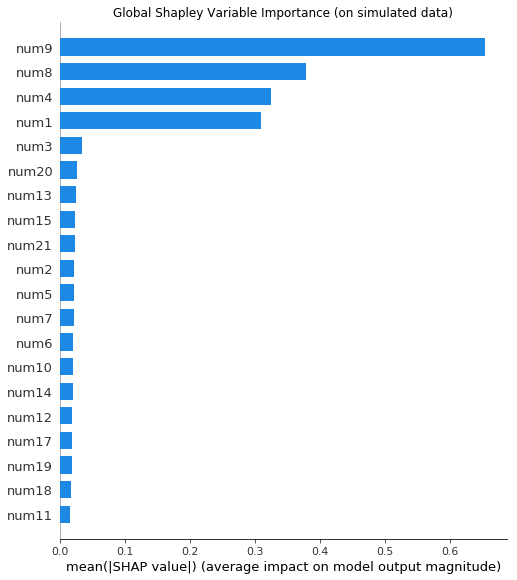

In [9]:
#Set all shapley values to their absolute value
shap_values_abs = np.absolute(shap_values[:,:-1])

#Plot mean absolute shapley across all classes for global shapley variable importance
plt.title("Global Shapley Variable Importance (on simulated data)")
shap.summary_plot(shap_values_abs, test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/global_shapley_simulated.png',bbox_inches='tight')
plt.close()

#To show in notebook
plt.title("Global Shapley Variable Importance (on simulated data)")
shap.summary_plot(shap_values_abs, test[xgb_model.feature_names], plot_type="bar")

### Global Eli5/Tree Interpreter Variable Importance

In [10]:
eli5.show_weights(xgb_model)

Weight,Feature
0.1721,num9
0.1379,num1
0.1260,num4
0.1069,num8
0.0287,num6
0.0277,num2
0.0275,num21
0.0275,num7
0.0274,num14
0.0272,num3


### Display signed Shapley variable importance summary

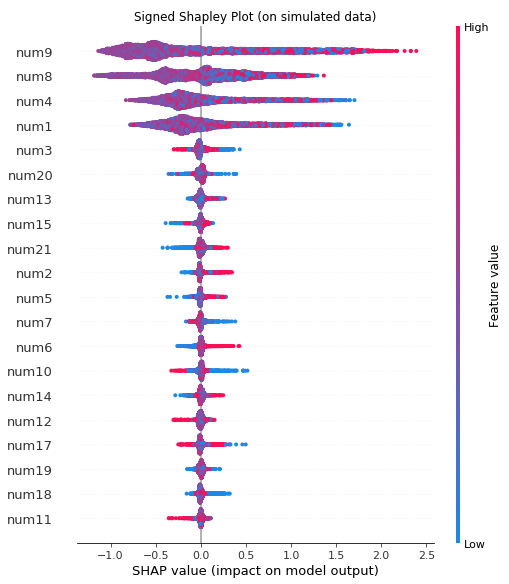

In [11]:
#Plot signed Shapley variable importance summary
plt.title("Signed Shapley Plot (on simulated data)")
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names], show=False)
plt.savefig('./images/shapley_signed_simulated' + ".png", bbox_inches='tight')
plt.close()
#To show in notebook
plt.title("Signed Shapley Plot (on simulated data)")
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

# Calculating partial dependence for a binomial model
Partial dependence plots are used to view the global, average prediction behavior of a variable under the binomial model. Partial dependence plots show the average prediction of the model as a function of specific values of an input variable of interest, indicating how the GBM predictions per class outcome change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the GBM's mechanisms and enable validation and debugging of the GBM by comparing a variable's average predictions per class across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

### Function for calculating binomial partial dependence

In [12]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    #Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache
    
    return par_dep_frame

### Calculate partial dependence for the most important input variable(s) in the GBM
`num9` is the most important variable according to global Shapley variable importance.

In [13]:
pdp_num9 = par_dep(xs="num9", frame=test[X], model=xgb_model, resolution=20, bins=None)
pdp_num9.head()

,num9,partial_dependence
0,-3.439412,0.709863
1,-3.084878,0.712634
2,-2.730344,0.714032
3,-2.375810,0.731797
4,-2.021276,0.693550


# Plotting binomial partial dependence

In [14]:
def plot_pdp(pdp_data, xs):
    fig, ax = plt.subplots()
    pdp_data.plot(x=xs,y="partial_dependence", ax=ax)
    plt.title("Binomial Partial Dependency Plot (simulated data)")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig("./images/global_pdp_simulated.png", bbox_inches='tight')
    plt.show()
    plt.close()

### PDP for `num9`

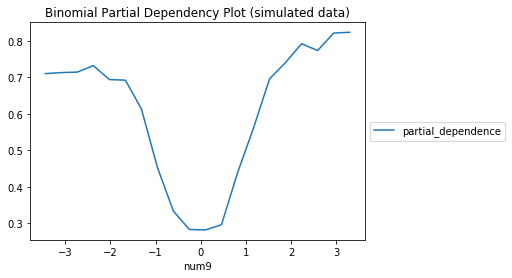

In [15]:
plot_pdp(pdp_num9, "num9")

# Calculating Individual Conditional Expectation (ICE) for a binomial model
Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions for being in class 0 and the row identifier (row_id), respectively.

In [16]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    #Create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    #Find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    #Find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

#### Find some percentiles of yhat in the test data
The values for ID that correspond to the maximum, minimum, and deciles of the target are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [17]:
#Merge XGBoost predictions onto test data 
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)

#Find percentiles of predictions
percentile_dict = get_percentile_dict('target', 'row_id', yhat_test)

#Display percentiles dictionary
#ID values for rows
#from lowest prediction 
#to highest prediction
percentile_dict

{0: 0,
 99: 5444,
 10: 12229,
 20: 27082,
 30: 20819,
 40: 4763,
 50: 3903,
 60: 12289,
 70: 11234,
 80: 14740,
 90: 4560}

### Calculate ICE curve values for `num9` against a particular `target` outcome in the test data

In [18]:
def calc_ice_curves(pdp_data, xs, id_col):
    """ Creates Pandas DataFrame containing partial dependence and ICE
    for a single variable
    
    Args:
        pdp_data: Data contain partial dependence for a specific variable
        xs: Variable for which to calculate partial dependence.
        id_col: Column name containing percentiles
        class_category: Class outcome of interest (an int ranging from 0-num_classes)
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence and ICE values for a specific class outcome.
        
    """
    #Retreive bins from original partial dependence calculation
    bins = list(pdp_data[xs])
    pdp_ice_data = pdp_data[[xs, "partial_dependence"]]
    #Fr each percentile in percentile_dict
    #create a new column in the par_dep frame 
    #representing the ICE curve for that percentile
    #and the variables of interest
    for i in sorted(percentile_dict.keys()):

        col_name = 'Percentile_' + str(i)

        # ICE curves for target across percentiles at bin intervals
        pdp_ice_data[col_name] = par_dep(xs, 
                                      test[test[id_col] == int(percentile_dict[i])][X],  
                                      xgb_model, 
                                      bins=bins)['partial_dependence']
    return pdp_ice_data

### Calculate ICE curve values for `num9` against `target` outcome, `0` 

In [19]:
pdp_num9_class_zero = calc_ice_curves(pdp_num9, "num9", "row_id")
pdp_num9_class_zero.head()

,num9,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-3.439412,0.709863,0.542993,0.839711,0.505913,0.565947,0.355088,0.389972,0.912656,0.799123,0.465084,0.775384,0.803894
1,-3.084878,0.712634,0.542993,0.849113,0.505913,0.565947,0.355088,0.389972,0.912656,0.799123,0.465084,0.787605,0.803894
2,-2.730344,0.714032,0.542993,0.852697,0.505913,0.569244,0.355088,0.393171,0.912656,0.799123,0.465084,0.791282,0.803894
3,-2.375810,0.731797,0.524673,0.875484,0.512244,0.567110,0.372224,0.379987,0.938626,0.824748,0.481284,0.811634,0.831805
4,-2.021276,0.693550,0.425558,0.865659,0.390563,0.468505,0.285608,0.358242,0.930812,0.804759,0.342988,0.799034,0.812579


# Plotting partial dependence and ICE

In [20]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        class_index: Class outcome of interest. XGBoost see's this as a value from 0-N where N is number of classes
    
    """
    
    #Initialize figure and axis
    fig, ax = plt.subplots()
    
    #Plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                                 colormap='gnuplot',
                                                                 ax=ax)

    #Overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    #Add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)
    
    plt.savefig("./images/pdp_ice_class_simulated.png", bbox_inches='tight')
    plt.show()
    plt.close()

### Plot PDP & ICE curves for `num9`

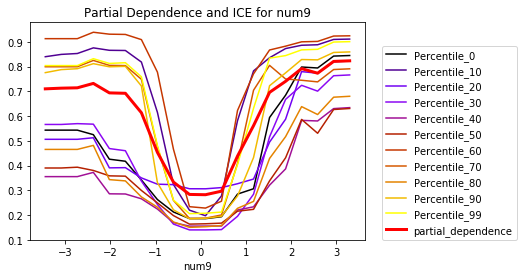

In [21]:
plot_par_dep_ICE('num9', pdp_num9_class_zero)